In [1]:
#confidence_levels.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#18 July 2018
#
#plot the CNET model's confidence levels

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 25
initial_id = 0

In [3]:
#generate sample of xo data
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
xo = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
#xo.tail()

In [4]:
#extract x-features and y = target variables
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
x = xo[x_cols].values
y = xo[y_cols].values
#print x.shape, y.shape

In [14]:
#load cnet model
from keras.models import load_model
model = load_model('cnet_model.h5')

In [6]:
#generate predictions and stash results in xo dataframe
#note that class scores are not yet normalized
y_pred = model.predict(x)     #wow this executes very slowly, why?!?
import pandas as pd
cols = [col + '_pred' for col in y_cols]
y_pred_df = pd.DataFrame(data=y_pred, columns=cols)

In [7]:
##comment out this debugging check, for report
#print 'y_pred_df min and max = ', y_pred_df.min().min(), y_pred_df.max().max()
#y_pred_df.head()

In [8]:
#normalize class scores...uses .iterrows() which is slow...
#.apply() would be much faster but i couldnt get that to work...
def fn(x):
    x -= x.min()
    x /= x.sum()
    return x
cols = y_pred_df.columns
for idx, row in y_pred_df.iterrows():
    y_pred_df.loc[idx, cols] = fn(row)
xo[cols] = y_pred_df[cols]
xo['class_score'] = xo.apply(lambda x: x[cols].max(), axis=1)
xo['class_pred'] = xo.apply(lambda x: cols[x[cols].values.argmax()][0], axis=1)

In [9]:
##comment out this debugging check, for report
#print 'class_score range = ', xo['class_score'].min(), xo['class_score'].max()

In [10]:
#kep this, for report
cols = ['id', 'x', 'y', 'class', 'class_score', 'class_pred']
xo[cols].head(10)

,id,x,y,class,class_score,class_pred
record,,,,,,
0,0,-3.061090,-3.598264,B,0.946631,X
1,1,7.371687,-2.348006,B,0.948489,B
2,2,3.240702,-1.021512,O,0.546929,O
3,3,-6.163388,-2.133983,B,0.889761,B
4,4,1.802831,0.243811,X,0.519442,X
5,5,-0.248380,2.590541,O,0.605660,O
6,6,-0.229955,1.295249,X,0.561463,X
7,7,-0.656173,4.681734,B,0.684823,B
8,8,0.636865,4.580877,B,0.639850,B


In [11]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

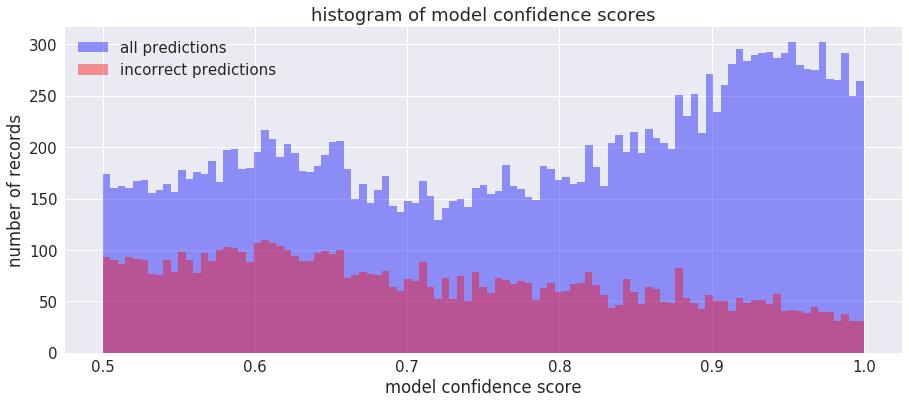

In [12]:
#histogram model confidence
N_bins = 101
fig, ax = plt.subplots(1,1, figsize=(15, 6))
#historgram all predictions
xp = xo.class_score
p = sns.distplot(xp, bins=N_bins, ax=ax, kde=False, color='blue', label='all predictions')
#histogram incorrect predictions
idx = (xo['class'] != xo['class_pred'])
xp = xo[idx].class_score
p = sns.distplot(xp, bins=N_bins, ax=ax, kde=False, color='red', label='incorrect predictions')
p = ax.set_title('histogram of model confidence scores')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('number of records')
p = ax.legend()
ax.figure.savefig('figs/cnet_confidence_scores.png')

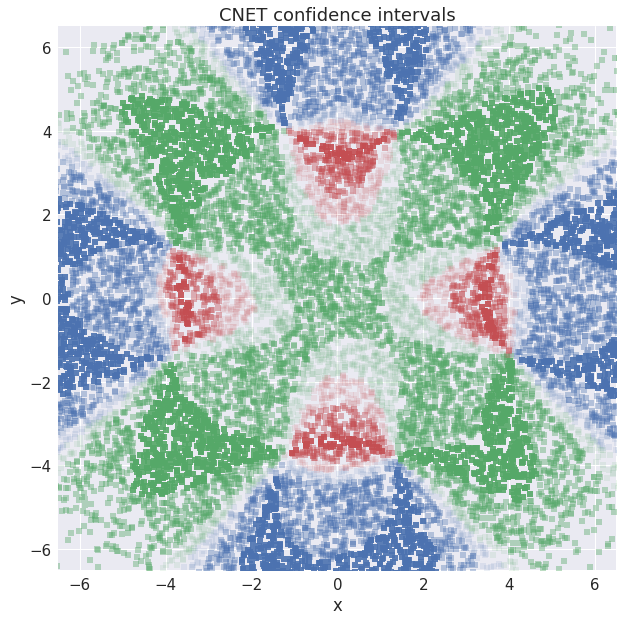

In [13]:
#scatterplot showing model's predicted decision boundaries
df = xo
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
clr_idx = -1
#B predictions having class_score>0.85
lbl = 'B'
clr_idx += 1
clr = colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][clr_idx]
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.85)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.9, 's': sz}, marker='s')
#B predictions having 0.7>class_score>0.85
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.6) & (df['class_score'] < 0.85)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.35, 's': sz}, marker='s')
#B predictions having class_score<0.7
idx = (df['class_pred'] == lbl) & (df['class_score'] < 0.6)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.1, 's': sz}, marker='s')
#X predictions having class_score>0.7
lbl = 'X'
clr_idx += 1
clr = colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][clr_idx]
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.85)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.9, 's': sz}, marker='s')
#X predictions having 0.5>class_score>0.7
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.6) & (df['class_score'] < 0.85)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.4, 's': sz}, marker='s')
#X predictions having class_score<0.5
idx = (df['class_pred'] == lbl) & (df['class_score'] < 0.6)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.1, 's': sz}, marker='s')
#O predictions having class_score>0.85
lbl = 'O'
clr_idx += 1
clr = colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][clr_idx]
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.85)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.9, 's': sz}, marker='s')
#X predictions having 0.7>class_score>0.85
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.6) & (df['class_score'] < 0.85)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.4, 's': sz}, marker='s')
#X predictions having class_score<0.7
idx = (df['class_pred'] == lbl) & (df['class_score'] < 0.6)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.1, 's': sz}, marker='s')
p = ax.set_title('CNET confidence intervals')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/cnet_confidence_boundary.png')